In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt
from jaxopt import OptaxSolver
import optax

In [2]:
# Set input dimension
v = 10000

# Set data and target complexity
alpha = 0.6
beta = 0.2

D_vec = jnp.power(jnp.arange(v)+1,-2*alpha)
D = jnp.diag(D_vec)

# Define target
b = jnp.power(jnp.arange(v)+1,-beta)

key = random.key(0)

2024-08-23 09:33:40.920279: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
@jit
def loss(theta,W,data):
    X, y = data
    return jnp.mean((X @ W @ theta - y)**2)

In [4]:
# Sample a batch of size B
def generate_data(B,subkey):
    Z = random.normal(subkey,shape=(B,v))
    X = D_vec * Z
    y = jnp.dot(X,b)

    return X,y

In [5]:
# Approximation of risk / test error
@jit
def risk(theta,W):
    Wtheta = W @ theta
    return jnp.sum(jnp.diag(jnp.outer(Wtheta,Wtheta)) * D_vec) + jnp.sum(D_vec * b**2) - 2 * jnp.sum(jnp.diag(W @ jnp.outer(theta,b)) * D_vec)

In [6]:
def optimize(gamma,B,flops,d,c,key):
    one = jnp.ones(shape=(d,))
    key, Z_key = random.split(key)
    Z = random.normal(Z_key, shape=(v,d)) / jnp.sqrt(d)
    W = c / jnp.sqrt(d) * jnp.outer(b,one) + Z    

    r = int(flops / (B*d))
    opt = optax.sgd(learning_rate=gamma)
    solver = OptaxSolver(opt=opt, fun=loss, maxiter=r)
    theta = jnp.zeros(d)
    key, subkey = random.split(key)
    data = generate_data(B,subkey)
    state = solver.init_state(theta, W=W, data=data)

    for _ in range(r):
        key, subkey = random.split(key)
        data = generate_data(B,subkey)
        theta, state = solver.update(theta, state, W=W, data=data)

    key, subkey = random.split(key)
    err = risk(theta,W)

    return theta, err

In [10]:
flops = jnp.logspace(4,7,4)
B = 1
gamma = 1e-1
dims = [160]
c = 0
n_flops = jnp.shape(flops)[0]
n_dims = len(dims)
risks = np.zeros((n_flops,n_dims))

for i, f in enumerate(flops):
    for j, d in enumerate(dims):
        print(f)
        key, subkey = random.split(key)
        theta, err = optimize(gamma,B,f,d,c,subkey)
        risks[i,j] = err

10000.0
100000.0
1000000.0
10000000.0


Text(0, 0.5, 'Risk')

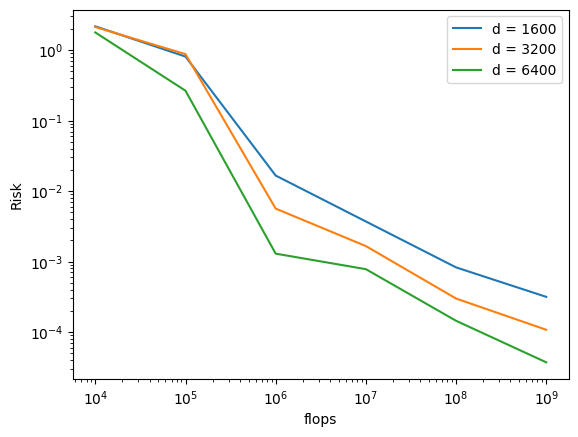

In [ ]:
for j,d in enumerate(dims):
    plt.plot(flops,risks[:,j],label="d = {}".format(d))
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("flops")
plt.ylabel("Risk")